![clothing_classification](clothing_classification.png)


Fashion Forward is a new AI-based e-commerce clothing retailer.
They want to use image classification to automatically categorize new product listings, making it easier for customers to find what they're looking for. It will also assist in inventory management by quickly sorting items.

As a data scientist tasked with implementing a garment classifier, your primary objective is to develop a machine learning model capable of accurately categorizing images of clothing items into distinct garment types such as shirts, trousers, shoes, etc.

In [2]:
# Run the cells below first

In [3]:
!pip install torchmetrics
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 57.1 MB/s eta 0:00:00
Defaulting to user installation because normal site-packages is not writeable


In [71]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall

In [72]:
# Load datasets
from torchvision import datasets
import torchvision.transforms as transforms

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [73]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [74]:
# Get the number of classes to train for

classes = train_data.classes
print(classes)
num_classes = len(train_data.classes)
print(num_classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
10


In [75]:
num_input_channels = 1
num_output_channels = 20
image_size = train_data[0][0].shape[1]
print(image_size)

28


In [76]:
# Define neural network
class MultiClassImageClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MultiClassImageClassifier, self).__init__()
        # Convolution Layer
        self.conv1 = nn.Conv2d(num_input_channels, num_output_channels, kernel_size=3, stride=1, padding=1)
        # ReLU Layer (does not change output size)
        self.relu = nn.ReLU()
        # MaxPooling Layer (output size decreases to 1/2 in both dimensions)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Flattening (output flattens out into vector)
        self.flatten = nn.Flatten()

        # Fully connected layer
        self.linear = nn.Linear(num_output_channels * (image_size//2)**2, num_classes)
        
    def forward(self, x):
        # Forward pass of input through each layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x
      

In [77]:
# Define DataLoader for the training set
dataloader_train = DataLoader(train_data, batch_size=int(len(train_data)/1000), shuffle=True)

In [78]:
# Define function for training the model (takes optimizer, neural network and number of epochs)
def train_model(optimizer, net, num_epochs):

    num_processed = 0
    criterion = nn.CrossEntropyLoss() # Good for multi-classification problems

    losses_list = []
    # Begin training loop (backward pass)
    for epoch in range(num_epochs):
        running_loss = 0
        num_processed = 0

        for features, labels in dataloader_train:
            optimizer.zero_grad() # Set all gradients to zero
            outputs = net(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            num_processed += len(labels)
        print(f'Epoch Number {epoch}: Loss encountered {running_loss / num_processed}')
        losses_list.append(running_loss / num_processed)
        
    train_loss = running_loss / len(dataloader_train)
    
    plt.plot(losses_list)
    plt.show()
    
    return train_loss

In [ ]:
# Initiate object of neural net
net = MultiClassImageClassifier(num_classes)
net.train()

# Initiate optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

Epoch Number 0: Loss encountered 0.007674077447131276
Epoch Number 1: Loss encountered 0.005313462622836232
Epoch Number 2: Loss encountered 0.0047495191132028896
Epoch Number 3: Loss encountered 0.004436620954796672
Epoch Number 4: Loss encountered 0.004188568101078272


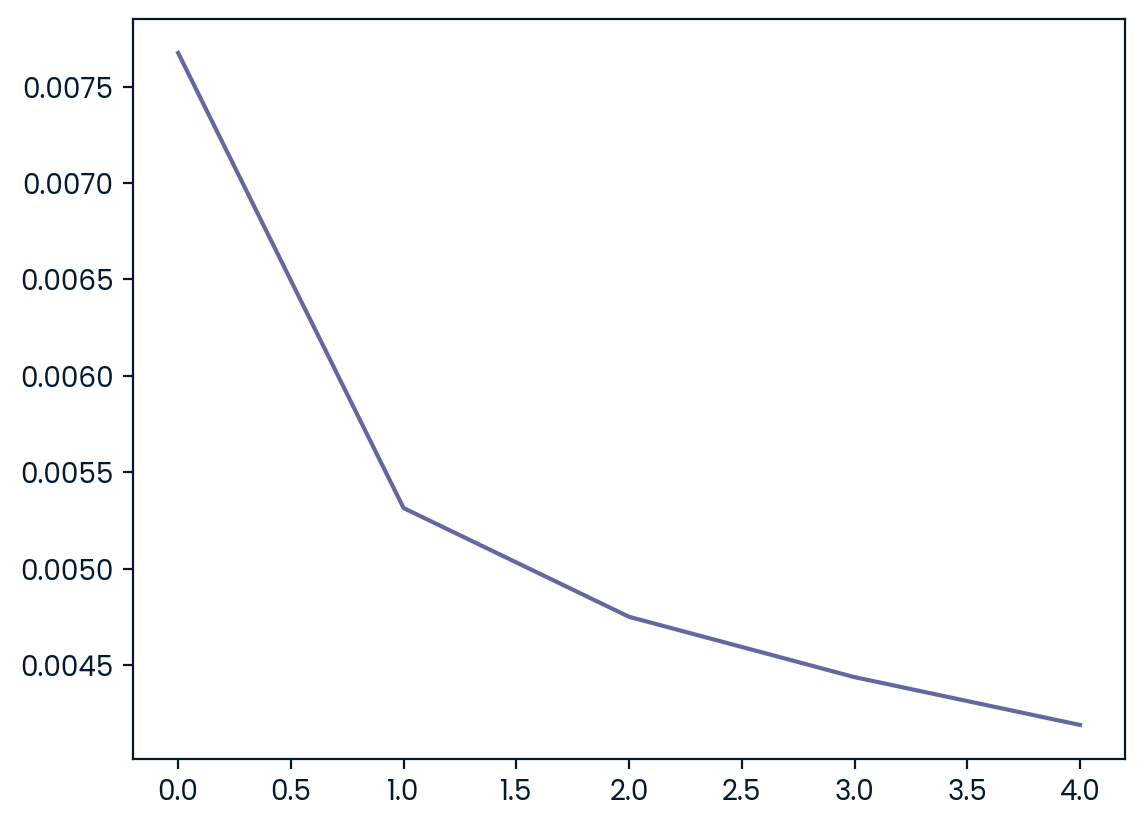

0.2513140860646963

In [79]:
# Train model for num_epochs --> 5
train_model(optimizer=optimizer, net=net, num_epochs=5)

### 5 epochs seems enough

In [80]:
# Making dataloader for my test_data
dataloader_test = DataLoader(test_data, batch_size=int(len(test_data)/1000), shuffle=True)
                             
# Defining the scores to use
acc = Accuracy(task='multiclass', num_classes=num_classes)
prec = Precision(task='multiclass', num_classes=num_classes, average=None)
recall = Recall(task='multiclass', num_classes=num_classes, average=None)

In [81]:
# Running my model on test set
net.eval() # Set to evaluation mode

predicted = []
for i, (features, labels) in enumerate(dataloader_test):
    output = net.forward(features.reshape(-1, 1, image_size, image_size)) # Running forward pass
    pred = torch.argmax(output, dim=-1)
    predicted.extend(pred.tolist())
    # Getting scores
    acc(pred, labels)
    prec(pred, labels)
    recall(pred, labels)

In [82]:
# Compute all scores
accuracy = acc.compute().item()
precision = prec.compute().tolist()
recal = recall.compute().tolist()
print('Model Accuracy:', accuracy)
print('Model Precision (per class):', precision)
print('Model Precision (average):', sum(precision)/(num_classes))
print('Model Recall (per class):', recal)
print('Model Recall (average):', sum(recal)/num_classes)

Model Accuracy: 0.8924999833106995
Model Precision (per class): [0.8512820601463318, 0.9867075681686401, 0.7720524072647095, 0.8803921341896057, 0.8684807419776917, 0.9897540807723999, 0.7040715217590332, 0.9432146549224854, 0.9787018299102783, 0.9697580933570862]
Model Precision (average): 0.8944415092468262
Model Recall (per class): [0.8299999833106995, 0.9649999737739563, 0.8840000033378601, 0.8980000019073486, 0.765999972820282, 0.9660000205039978, 0.7089999914169312, 0.9800000190734863, 0.9649999737739563, 0.9620000123977661]
Model Recall (average): 0.8924999952316284
